In [2]:
%pip install matplotlib
import pandas as pd
import folium, json
import numpy as np 
import statsmodels.api as sm 
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr 
from statsmodels.stats.multitest import multipletests


Note: you may need to restart the kernel to use updated packages.


In [3]:
weather_df = pd.read_csv("../data/raw/weather/weather.csv")

# should be run only ONCE
weather_df["TemperatureAboveGround"] = weather_df["TemperatureAboveGround"] - 273.15

sweden_weather_df = weather_df[weather_df["iso3166-2"].str.startswith("SE")]

#weather variables per day per region


corona_df = pd.read_csv("../data/raw/corona/se_corona.csv", sep = "\t")
#number of cases per day per region

corona_df = corona_df.rename(columns = {"confirmed_addition":"cases"})

with open("../data/raw/metadata/se_metadata.json", "r", encoding="utf-8") as f:
    country_metadata = json.load(f)

#population and region code per region




In [4]:
# Stringency Index

str_df = pd.read_csv("../data/raw/corona/stringency_index.csv")
str_df = str_df[(str_df["country_name"] == "Sweden")]

str_df = str_df.transpose()
str_df = str_df[3:].dropna() #dropping NA values


str_df = str_df.reset_index()
str_df = str_df.rename(columns={"index": "date", 157: "stringency_index"})

#changing string object to datetime
str_df["date"] = pd.to_datetime(str_df["date"], format="%d%b%Y")
str_df["date"] = str_df["date"].dt.date

In [5]:
#check for missing data
sweden_weather_df.isna().any().any()
corona_df.isna().any().any()
#cannot run a "isna" on dictionary, should we check for empty key?

False

In [6]:
region_map = {country_metadata["country_metadata"][i]["covid_region_code"]: country_metadata["country_metadata"][i]["iso3166-2_code"] for i in range (len(country_metadata["country_metadata"]))
}

corona_df ["region"] = corona_df["region_code"].map(region_map)

corona_df

,date,region_code,cases,region
0,2021-02-18,Blekinge,23,SE-K
1,2021-02-17,Blekinge,30,SE-K
2,2021-02-16,Blekinge,50,SE-K
3,2021-02-15,Blekinge,3,SE-K
4,2021-02-14,Blekinge,3,SE-K
...,...,...,...,...
7996,2020-02-08,Östergötland,0,SE-E
7997,2020-02-07,Östergötland,0,SE-E
7998,2020-02-06,Östergötland,0,SE-E
7999,2020-02-05,Östergötland,0,SE-E


In [7]:
population_map = {country_metadata["country_metadata"][i]["iso3166-2_code"]: country_metadata["country_metadata"][i]["population"] for i in range (len(country_metadata["country_metadata"]))
}

population_map

corona_df["population"] = corona_df["region"].map(population_map) #adding another column
corona_df["cases_per_capita"] = corona_df["cases"]/corona_df["population"] #adding our factor - cases per capita

corona_df

,date,region_code,cases,region,population,cases_per_capita
0,2021-02-18,Blekinge,23,SE-K,159606,0.000144
1,2021-02-17,Blekinge,30,SE-K,159606,0.000188
2,2021-02-16,Blekinge,50,SE-K,159606,0.000313
3,2021-02-15,Blekinge,3,SE-K,159606,0.000019
4,2021-02-14,Blekinge,3,SE-K,159606,0.000019
...,...,...,...,...,...,...
7996,2020-02-08,Östergötland,0,SE-E,465495,0.000000
7997,2020-02-07,Östergötland,0,SE-E,465495,0.000000
7998,2020-02-06,Östergötland,0,SE-E,465495,0.000000
7999,2020-02-05,Östergötland,0,SE-E,465495,0.000000


In [8]:
merged_df = corona_df.merge(sweden_weather_df, left_on=["date", "region"], right_on= ["date", "iso3166-2"]) 
#it matches two arguments, not merges on them. If you call the same thing twice, there will be one coulmn, but if you call two, it's different

merged_df = merged_df.drop("iso3166-2", axis = 1)
merged_df = merged_df.rename(columns = {"region_code":"region_name", "region": "region_code"})

merged_df["date"] = pd.to_datetime(merged_df["date"], format="%Y-%m-%d") #converting string type to datetime to match in merge with SI
merged_df["date"] = merged_df["date"].dt.date

merged_df

,date,region_name,cases,region_code,population,cases_per_capita,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed
0,2021-02-18,Blekinge,23,SE-K,159606,0.000144,91.958400,4.169385e+05,2.424771e+06,-0.351750,0.000317,0.572565,4.132720
1,2021-02-17,Blekinge,30,SE-K,159606,0.000188,93.411977,1.077138e+04,2.414730e+06,-0.790881,0.011454,0.001988,4.702286
2,2021-02-16,Blekinge,50,SE-K,159606,0.000313,84.177924,2.432986e+05,2.422795e+06,-0.865423,0.000768,0.083499,2.609667
3,2021-02-15,Blekinge,3,SE-K,159606,0.000019,82.131470,2.248502e+06,2.453097e+06,-4.712765,0.000055,3.000000,1.986150
4,2021-02-14,Blekinge,3,SE-K,159606,0.000019,63.394010,5.284755e+06,2.467144e+06,-4.158823,0.000000,3.000000,3.567992
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7807,2020-02-17,Östergötland,0,SE-E,465495,0.000000,78.950564,3.140092e+06,2.346177e+06,5.385988,0.000694,0.805748,8.579413
7808,2020-02-16,Östergötland,0,SE-E,465495,0.000000,89.385446,3.497807e+04,2.343163e+06,7.423016,0.010469,0.000000,7.294057
7809,2020-02-15,Östergötland,0,SE-E,465495,0.000000,89.326442,6.666688e+04,2.393343e+06,3.846002,0.003482,0.000000,4.671259
7810,2020-02-14,Östergötland,0,SE-E,465495,0.000000,88.093761,2.377418e+06,2.405543e+06,-0.174760,0.000005,1.056413,1.717806


In [9]:
str_df_regions = pd.concat([str_df], ignore_index=True) #in Sweden there are 21 regions

full_df = merged_df.merge(str_df_regions, on = "date") 

full_df

,date,region_name,cases,region_code,population,cases_per_capita,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed,stringency_index
0,2021-02-18,Blekinge,23,SE-K,159606,0.000144,91.958400,4.169385e+05,2.424771e+06,-0.351750,0.000317,0.572565,4.132720,69.44
1,2021-02-18,Dalarna,78,SE-W,287966,0.000271,83.472412,5.560170e+05,2.327816e+06,-6.324020,0.000902,0.000000,2.789497,69.44
2,2021-02-18,Gotland,3,SE-I,59686,0.000050,76.066474,1.217169e+06,2.449967e+06,-3.398588,0.000011,2.044527,4.697774,69.44
3,2021-02-18,Gävleborg,234,SE-X,287382,0.000814,77.955185,1.722268e+06,2.383899e+06,-5.956068,0.000124,0.000000,2.564518,69.44
4,2021-02-18,Halland,187,SE-N,333848,0.000560,91.276936,6.979065e+03,2.410299e+06,0.282810,0.000647,0.000000,4.960031,69.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7807,2020-02-13,Västernorrland,0,SE-Y,245347,0.000000,83.230208,1.351595e+06,2.320155e+06,-6.075210,0.000045,0.000000,1.497883,5.56
7808,2020-02-13,Västmanland,0,SE-U,275845,0.000000,71.129740,3.511075e+06,2.373874e+06,-0.460946,0.000000,0.000000,2.593358,5.56
7809,2020-02-13,Västra_Götaland,0,SE-O,1725881,0.000000,77.017705,3.841654e+06,2.370478e+06,1.299874,0.000039,0.792579,3.868366,5.56
7810,2020-02-13,Örebro,0,SE-T,304805,0.000000,69.266165,3.927441e+06,2.358019e+06,-0.298819,0.000000,0.000000,3.391266,5.56


region_code
SE-AB    AxesSubplot(0.125,0.125;0.775x0.755)
SE-AC    AxesSubplot(0.125,0.125;0.775x0.755)
SE-BD    AxesSubplot(0.125,0.125;0.775x0.755)
SE-C     AxesSubplot(0.125,0.125;0.775x0.755)
SE-D     AxesSubplot(0.125,0.125;0.775x0.755)
SE-E     AxesSubplot(0.125,0.125;0.775x0.755)
SE-F     AxesSubplot(0.125,0.125;0.775x0.755)
SE-G     AxesSubplot(0.125,0.125;0.775x0.755)
SE-H     AxesSubplot(0.125,0.125;0.775x0.755)
SE-I     AxesSubplot(0.125,0.125;0.775x0.755)
SE-K     AxesSubplot(0.125,0.125;0.775x0.755)
SE-M     AxesSubplot(0.125,0.125;0.775x0.755)
SE-N     AxesSubplot(0.125,0.125;0.775x0.755)
SE-O     AxesSubplot(0.125,0.125;0.775x0.755)
SE-S     AxesSubplot(0.125,0.125;0.775x0.755)
SE-T     AxesSubplot(0.125,0.125;0.775x0.755)
SE-U     AxesSubplot(0.125,0.125;0.775x0.755)
SE-W     AxesSubplot(0.125,0.125;0.775x0.755)
SE-X     AxesSubplot(0.125,0.125;0.775x0.755)
SE-Y     AxesSubplot(0.125,0.125;0.775x0.755)
SE-Z     AxesSubplot(0.125,0.125;0.775x0.755)
Name: cases, dtype: ob

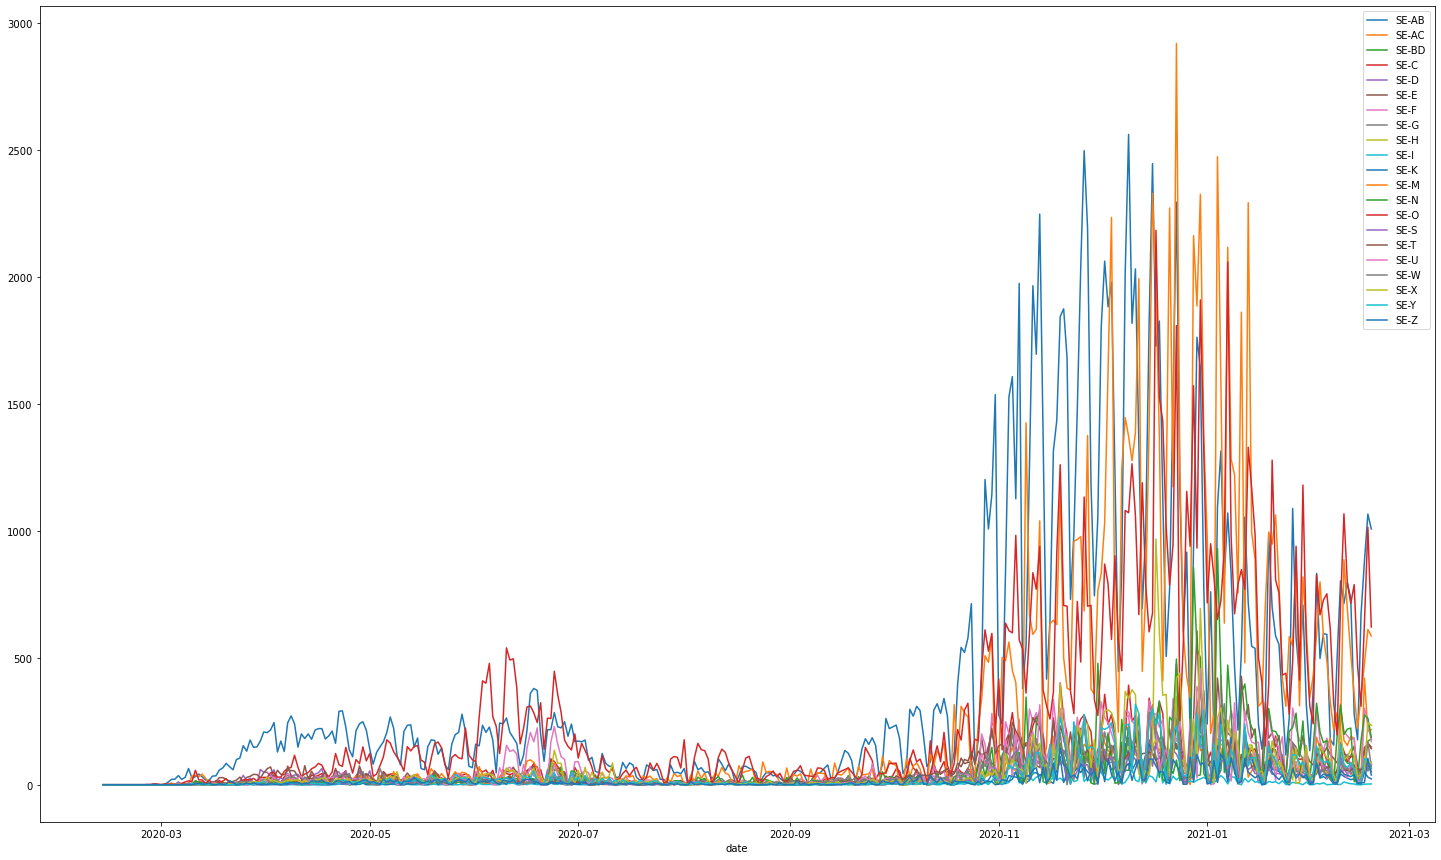

In [10]:
# plot cases per region over time. num of cases on y axis, date on x axis
full_df.set_index(keys="date", inplace= True,)
full_df.groupby("region_code")["cases"].plot(legend=True,figsize=(25,15))



In [12]:
sweden_weather_df

,date,iso3166-2,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed
33,2020-02-13,SE-AB,77.031734,3.628275e+06,2.389095e+06,-0.028422,0.000000,0.000000,3.675591
34,2020-02-13,SE-AC,93.144776,1.134221e+06,2.268189e+06,-11.221602,0.000194,0.000000,1.294817
35,2020-02-13,SE-BD,84.985182,5.838355e+05,2.250394e+06,-13.614288,0.000112,0.000000,1.603159
36,2020-02-13,SE-C,80.092733,3.148763e+06,2.386330e+06,-1.042436,0.000000,0.000000,2.669467
37,2020-02-13,SE-D,70.096824,3.900326e+06,2.387066e+06,0.449179,0.000000,0.000000,3.631942
...,...,...,...,...,...,...,...,...,...
20215,2021-02-21,SE-U,91.916597,7.916121e+05,2.410170e+06,3.921493,0.001779,1.422222,2.021353
20216,2021-02-21,SE-W,96.715902,1.615278e+05,2.317050e+06,1.931778,0.001388,0.003466,2.420327
20217,2021-02-21,SE-X,95.125765,7.512086e+04,2.371164e+06,1.104015,0.002848,0.000305,1.859193
20218,2021-02-21,SE-Y,88.577506,8.054834e+02,2.363886e+06,-5.334785,0.003638,0.000000,2.610603


array([<AxesSubplot:title={'center':'RelativeHumiditySurface'}, xlabel='date'>,
       <AxesSubplot:title={'center':'SolarRadiation'}, xlabel='date'>,
       <AxesSubplot:title={'center':'Surfacepressure'}, xlabel='date'>,
       <AxesSubplot:title={'center':'TemperatureAboveGround'}, xlabel='date'>,
       <AxesSubplot:title={'center':'Totalprecipitation'}, xlabel='date'>,
       <AxesSubplot:title={'center':'UVIndex'}, xlabel='date'>,
       <AxesSubplot:title={'center':'WindSpeed'}, xlabel='date'>],
      dtype=object)

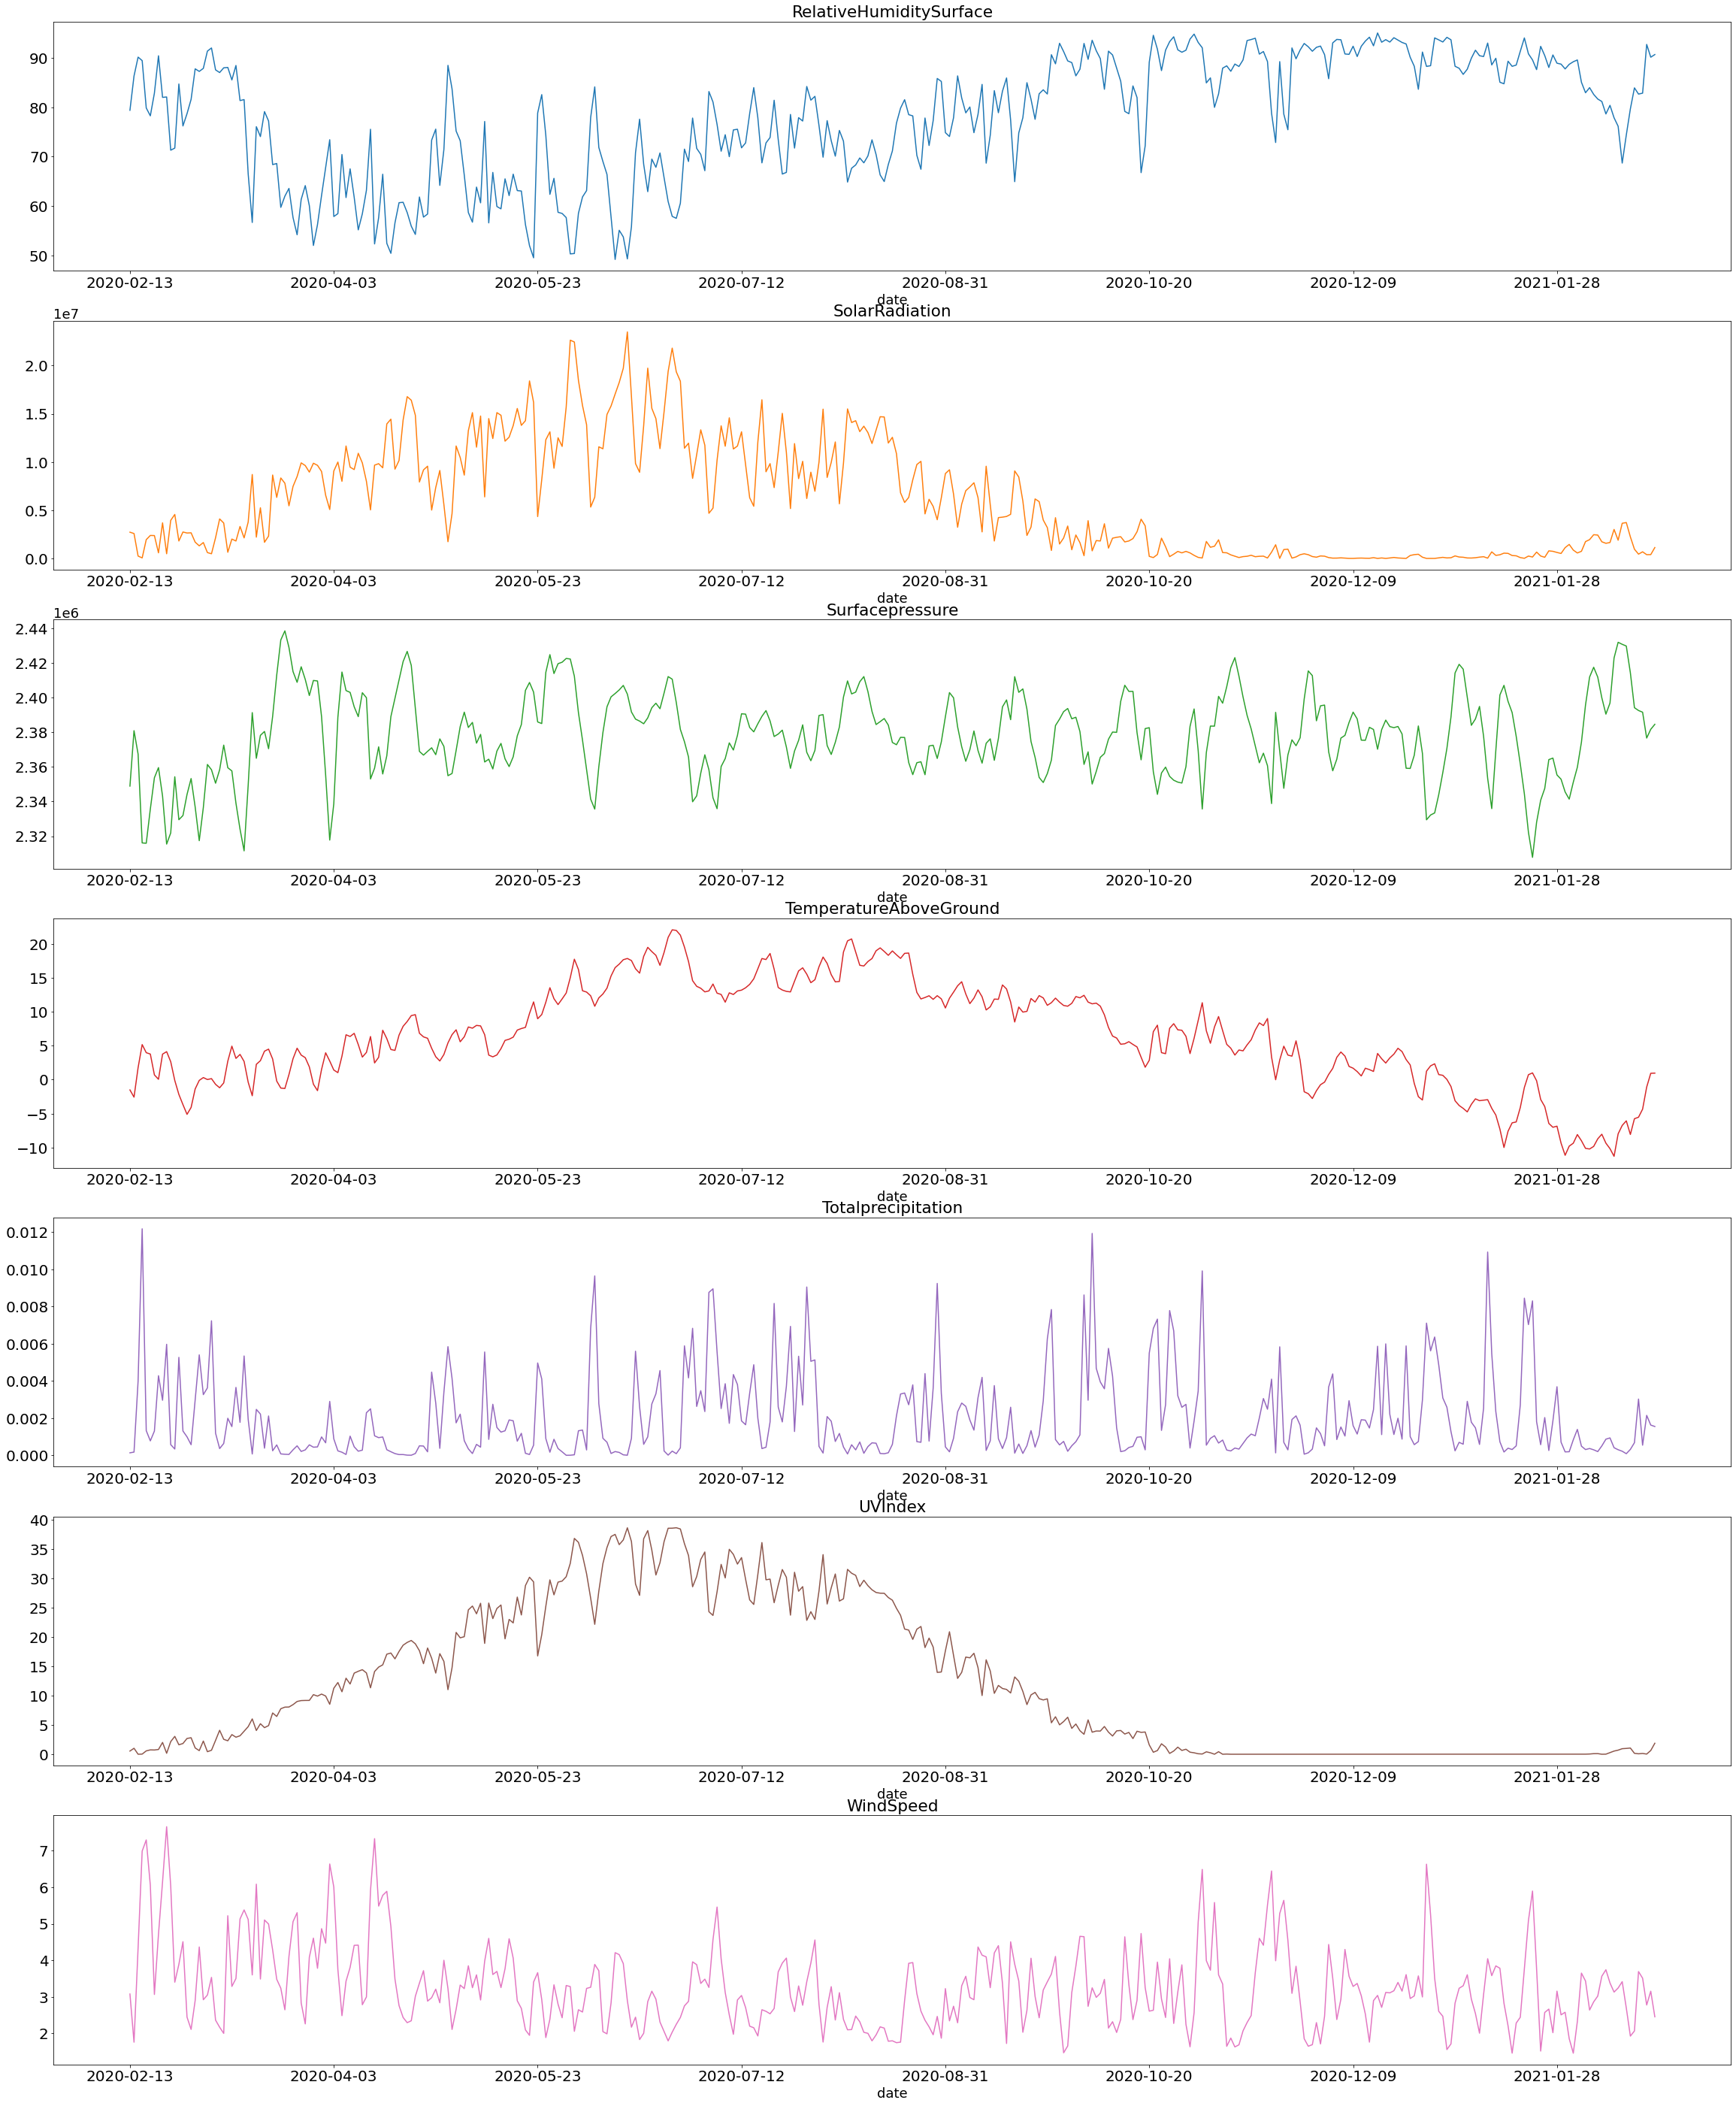

In [13]:
sweden_weather_df_date = sweden_weather_df.drop("iso3166-2", axis=1)
weather_variable_subplot = sweden_weather_df_date.groupby("date").agg("mean") #I don't get what this aggregate does
plt.rcParams.update({"font.size":18})
Xs= ["RelativeHumiditySurface", "SolarRadiation", "Surfacepressure", "TemperatureAboveGround", "Totalprecipitation", "UVIndex", "WindSpeed"]
weather_variable_subplot.plot(subplots=True, figsize= (40,50), legend=False, sharex=False, title=Xs, fontsize=20 )


In [ ]:
Xs= ["RelativeHumiditySurface", "SolarRadiation", "Surfacepressure", "TemperatureAboveGround", "Totalprecipitation", "UVIndex", "WindSpeed"]

significance_threshold = 0.005/7


for var in Xs: 
    corr, pvalue = pearsonr(full_df["cases"], full_df[var])
    print(f"{var}\n{corr:.3f}\t{pvalue}\t{pvalue < significance_threshold}\n")




RelativeHumiditySurface
0.217	3.907016922024001e-84	True

SolarRadiation
-0.222	5.0086720589042216e-88	True

Surfacepressure
0.130	6.031849091292155e-31	True

TemperatureAboveGround
-0.148	1.8154672522899836e-39	True

Totalprecipitation
0.016	0.15940712901941428	False

UVIndex
-0.233	4.673663032768274e-97	True

WindSpeed
0.043	0.00016318892865581133	True



In [ ]:
#Spearman bonferroni


Xs= ["RelativeHumiditySurface", "SolarRadiation", "Surfacepressure", "TemperatureAboveGround", "Totalprecipitation", "UVIndex", "WindSpeed"]

significance_threshold = 0.005/7  

for var in Xs: 
    corr, pvalue = spearmanr(full_df["cases"], full_df[var])
    print(f"{var}\n{corr:.3f}\t{pvalue}\t{pvalue < significance_threshold}\n")

RelativeHumiditySurface
0.267	9.832250385730405e-128	True

SolarRadiation
-0.342	2.440997668619903e-213	True

Surfacepressure
0.155	2.411947739843351e-43	True

TemperatureAboveGround
-0.217	7.300739352215883e-84	True

Totalprecipitation
0.005	0.6392701606505318	False

UVIndex
-0.357	3.5946834739162764e-233	True

WindSpeed
-0.044	9.061463229959151e-05	True



In [ ]:
#Pearson log Bonferroni
Xs= ["RelativeHumiditySurface", "SolarRadiation", "Surfacepressure", "TemperatureAboveGround", "Totalprecipitation", "UVIndex", "WindSpeed"]

significance_threshold = 0.005/7 

for var in Xs: 
    corr, pvalue = pearsonr(np.log(full_df["cases"]+1), full_df[var])
    print(f"{var}\n{corr:.3f}\t{pvalue}\t{pvalue < significance_threshold}\n")

RelativeHumiditySurface
0.231	2.604923083457697e-95	True

SolarRadiation
-0.237	7.023729900514718e-100	True

Surfacepressure
0.175	8.922852858988767e-55	True

TemperatureAboveGround
-0.213	8.560860967206382e-81	True

Totalprecipitation
-0.025	0.030077619016782336	False

UVIndex
-0.245	4.3917687284067084e-107	True

WindSpeed
-0.060	1.359386703674533e-07	True



In [ ]:
#Holm-Bonferroni correction 
#This is needed as there is at least a saml chance htat our variables are interdependent, therefore bonferroni is too strict a measure
Xs= ["RelativeHumiditySurface", "SolarRadiation", "Surfacepressure", "TemperatureAboveGround", "Totalprecipitation", "UVIndex", "WindSpeed"]
pvalues = []
tests = ("linear", "spearman", "log")

for var in Xs:
    corr, pvalue = pearsonr(full_df["cases"], full_df[var])
    pvalues.append(pvalue)

for var in Xs:
    corr, pvalue = spearmanr(full_df["cases"], full_df[var])
    pvalues.append(pvalue)

for var in Xs: 
    corr, pvalue = pearsonr(np.log(full_df["cases"]+1), full_df[var])
    pvalues.append(pvalue)
    

    
significant, pholmcorrected, _ , _ = multipletests(pvalues, alpha = 0.005, method = "holm")

for i in range(len(tests)):
    for j in range(len(Xs)):
        print(f"{tests[i]}\t{Xs[j]}\t{significant[i+j]}")


linear	RelativeHumiditySurface	True
linear	SolarRadiation	True
linear	Surfacepressure	True
linear	TemperatureAboveGround	True
linear	Totalprecipitation	False
linear	UVIndex	True
linear	WindSpeed	True
spearman	RelativeHumiditySurface	True
spearman	SolarRadiation	True
spearman	Surfacepressure	True
spearman	TemperatureAboveGround	False
spearman	Totalprecipitation	True
spearman	UVIndex	True
spearman	WindSpeed	True
log	RelativeHumiditySurface	True
log	SolarRadiation	True
log	Surfacepressure	False
log	TemperatureAboveGround	True
log	Totalprecipitation	True
log	UVIndex	True
log	WindSpeed	True
